In [1]:
# ! pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

_FOLDER = "../data/"
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor

## autoML
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


import json

In [2]:
def createResponseCurve(iD,model, xValues, yValues, predicted = False):
    plt.scatter(xValues, yValues)
    plt.title(model + " " + iD)
    plt.xlabel("Scaled dosage")
    if(predicted):
        plt.ylabel("Predicted Normalised response")
    else:
        plt.ylabel("Normalised response")
    plt.show()


with open(_FOLDER + 'dataSplit.json') as json_file:
    trainTestSplit = json.load(json_file)

In [3]:
drugProfiles = pd.read_csv(_FOLDER+'filteredResponsesWithCCLAndParams.csv')
drugProfiles

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,HDQ-P1,1290922,344,344_1290922,20.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
1,HDQ-P1,1290922,136,136_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
2,HDQ-P1,1290922,170,170_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
3,NMC-G1,908449,170,170_908449,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
4,NMC-G1,908449,331,331_908449,10.24,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,TC-YIK,946357,1011,1011_946357,2.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5580,MKN45,925340,1149,1149_925340,5.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5581,EC-GI-10,753555,1004,1004_753555,0.10,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5582,IGROV-1,905968,1031,1031_905968,0.20,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(trainTestSplit.keys())

88

In [5]:
def objective(params):
    model = xgb.XGBRegressor(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        gamma=params['gamma'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        min_child_weight=params['min_child_weight'],
        random_state=42
    )
    mse = -np.mean(cross_val_score(model, trainX, trainY, cv=5, scoring='neg_mean_squared_error'))
    return mse



In [7]:
notIncludeColumns = ['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID','MAX_CONC', 'param_1', 'param_2','param_3','param_4']
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels

predictedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ resp_labels)

drugId = 344

drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
tr, val = train_test_split(trainTestSplit[str(drugId)][0], test_size=0.3, random_state=42)

trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(tr)]
notXValuesFilter = resp_labels + notIncludeColumns + conc_labels
trainXValues = trainData.drop(columns = notXValuesFilter)
trainYValues = trainData[resp_labels]
trainX = trainXValues.reset_index(drop=True).to_numpy()
trainY = trainYValues.reset_index(drop=True).to_numpy()

valData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(val)]
valXValues = valData.drop(columns = notXValuesFilter)
valYValues = valData[resp_labels]
valX = valXValues.reset_index(drop=True).to_numpy()
valY = valYValues.reset_index(drop=True).to_numpy()

testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
testXValues = testData.drop(columns = notXValuesFilter)
testYValues = testData[resp_labels]
testX = testXValues.reset_index(drop=True).to_numpy()
testY = testYValues.reset_index(drop=True).to_numpy()

model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, gamma=0.085, subsample=0.8, colsample_bytree=0.8, reg_lambda=1, reg_alpha=0, min_child_weight=1)
model.fit(trainX, trainY)

preds = model.predict(testX)

result = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
result[pred_resp_labels] = preds
predictedResults = predictedResults.append(result,ignore_index=True,sort=False)
test_mse = mean_squared_error(preds, testY)
trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
trueResult[resp_labels] = testY
trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)
# print(test_mse)

In [8]:
trueResults

,DRUG_COSMICID,norm_cells_0,norm_cells_1,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9
0,344_910851,1.0,0.971586,0.906044,0.954482,0.917586,0.279158,0.258352,0.233342,0.204716,0.197107
1,344_717431,1.0,1.037550,1.091360,1.143341,1.097121,0.947674,0.659068,0.011337,0.015206,0.015280
2,344_910925,1.0,1.029277,1.108623,0.851732,0.782264,0.013142,0.003812,0.004973,0.006074,0.007326
3,344_908457,1.0,1.013743,1.001765,0.947623,0.911589,0.695498,0.440803,0.173345,0.013123,0.009104
4,344_910853,1.0,0.951634,0.922052,0.687362,0.582085,0.006510,0.004951,0.006649,0.003550,0.003617
5,344_908123,1.0,0.967067,0.945210,0.987415,0.996366,0.913169,0.745015,0.009191,0.005302,0.006474
6,344_905962,1.0,1.005736,0.992808,0.995439,0.973973,0.444915,0.193558,0.004517,0.005456,0.002408
7,344_722045,1.0,0.968492,0.976498,0.898752,0.746105,0.180655,0.086766,0.020786,0.006432,0.006455
8,344_917486,1.0,0.986723,0.914477,1.061182,0.754083,0.253797,0.016887,0.008990,0.010619,0.008801
9,344_906826,1.0,1.000641,1.065012,1.057747,0.963716,0.457469,0.286658,0.260749,0.062882,0.024845


In [9]:
predictedResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,344_910851,0.999984,1.009495,0.995522,0.991478,0.867150,0.714779,0.138969,0.206413,0.008619,0.007957
1,344_717431,0.999984,1.009495,0.995522,0.649220,0.657986,0.624354,0.094459,0.043192,0.008619,0.007957
2,344_910925,0.999984,1.009495,0.995522,0.991478,0.834673,0.609194,0.198559,0.042683,0.008619,0.007957
3,344_908457,0.999984,1.009495,0.995522,0.991478,0.875687,0.494749,0.131917,0.043192,0.008619,0.007957
4,344_910853,0.999984,1.009495,0.995522,1.001728,0.920916,0.641168,0.529803,0.417583,0.008619,0.007957
5,344_908123,0.999984,1.009495,0.995522,0.975176,0.854782,0.412515,0.088368,0.037888,0.008619,0.007957
6,344_905962,0.999984,1.009495,0.995522,0.991478,0.898738,0.633306,0.249085,0.037888,0.008619,0.007957
7,344_722045,0.999984,1.009495,0.995522,0.978978,0.798584,0.613645,0.127215,0.100411,0.008619,0.007957
8,344_917486,0.999984,1.009495,0.995522,0.978978,0.826985,0.699230,0.253153,0.043192,0.008619,0.007957
9,344_906826,0.999984,1.009495,0.995522,0.991478,0.885142,0.666975,0.265285,0.063283,0.008619,0.007957


In [37]:
def showTestPredResponses(drugIdCosmic):
    samplePredicted = predictedResults[predictedResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    predictedY = samplePredicted[pred_resp_labels]
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    xValues = [0, 0.111111111, 0.222222222, 0.333333333, 0.444444444, 0.555555556, 0.666666667, 0.777777778, 0.888888889, 1]
    trueY = trueY[resp_labels]
    plt.title(drugIdCosmic + " dosage against response")
    plt.scatter(xValues, predictedY, color='b', label='Predicted')
    plt.scatter(xValues, trueY, color='y', label='True')
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.show()

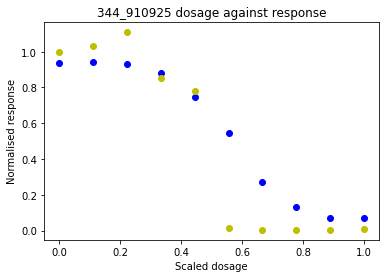

In [38]:
showTestPredResponses('344_910925')

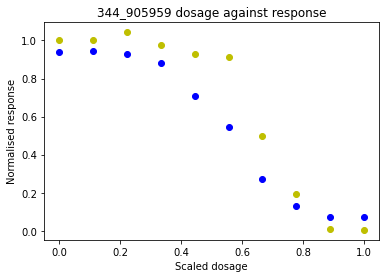

In [40]:
showTestPredResponses('344_905959')

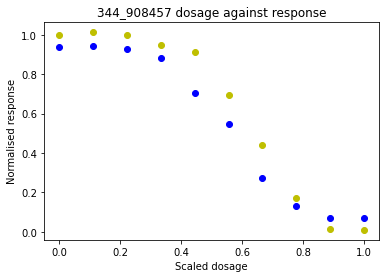

In [41]:
showTestPredResponses('344_908457')

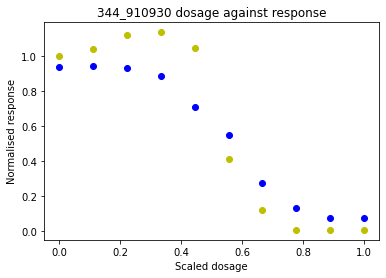

In [42]:
showTestPredResponses('344_910930')